# 1. EirGrid Renewable Energy & Demand Pipeline — Project Overview

This project implements a production-style data engineering and forecasting pipeline for electricity system data published by EirGrid’s Smart Grid Dashboard. The pipeline ingests high-frequency operational data for:

- System demand (MW)

- Wind generation (MW)

- Solar generation (MW)

Data is published by EirGrid at a 15-minute resolution and reflects Ireland’s national electricity system.

The primary objective of this project is to demonstrate how raw, externally sourced time-series data can be transformed into trustworthy, analytics-ready datasets through disciplined engineering practices.

### What the pipeline does

- Fetches data from the Smart Grid Dashboard API for wind, solar, and demand

- Parses and normalizes timestamps, converting Europe/Dublin local time to canonical UTC

- Stages raw readings in an append-only table to preserve source truth

- Promotes complete daily slices into canonical fact tables using idempotent logic

- Trains rolling forecasting models on historical data

- Generates next-day forecasts for demand, wind, and solar at 15-minute resolution

- Exports analytics-ready datasets for downstream BI and evaluation

All execution is performed via command-line interfaces and scheduled jobs, making the pipeline suitable for automation in both Linux cron and Windows Task Scheduler environments.

### Why this project exists


The project is designed to showcase:

- Robust API ingestion with retry and validation

- Timezone-safe and DST-aware time-series handling

- Clean separation between raw, staged, and canonical data

- Idempotent daily processing that is safe to rerun

- Rolling forecast generation without data leakage

- Practical integration with business intelligence tools (Power BI)

Rather than focusing solely on modeling, the emphasis is on building a reliable end-to-end data system that supports analytics, forecasting, and reporting with confidence.

### What this notebook is / is not

This notebook is intentionally read-only and explanatory.

It exists to:

- Explain the system architecture

- Inspect database outputs

- Demonstrate data correctness and structure

It does not:

- Run ingestion jobs

- Modify database state

- Generate forecasts

- Replace the CLI-driven pipeline

All production behavior is executed through Python modules and scheduled tasks, not notebooks.

### Downstream usage

The outputs of this pipeline are consumed by:

- Power BI dashboards for demand vs forecast analysis

- Forecast accuracy evaluation (MAE, RMSE, MAPE)

- Future extensions such as real-time dashboards or cloud warehouses

This notebook serves as a guided walkthrough for reviewers, recruiters, and collaborators to understand how the system works end-to-end.

# 2. System Architecture & Data Flow

At a high level, data flows through the system as follows:

- External API ingestion

- Raw staging (append-only)

- Canonical fact promotion

- Forecast generation

- Analytics export for BI

### High-level architecture

EirGrid API ->
Ingestion (fetch_data.py) -> 
Raw Staging (stg_readings) -> Canonical Facts (fact_readings) -> Forecasts (fact_forecasts) -> Parquet Export -> Power BI


### Ingestion layer (API → tidy data)

The ingestion layer is responsible for fetching data from the EirGrid Smart Grid Dashboard API and converting it into a clean, structured format.

Key responsibilities:

- Building API requests for wind, solar, and demand

- Handling temporary API failures using retry and backoff

- Rejecting malformed or invalid responses

- Parsing timestamps supplied in Europe/Dublin local time

- Converting all timestamps to UTC

- Producing a tidy, row-based dataset ready for storage

At this stage, data is only validated and reshaped — no deduplication or filtering decisions are made.

### Staging layer (raw data)

The staging table (stg_readings) is where all ingested data is stored exactly as received, after basic parsing and timestamp conversion.

Key characteristics:

- New data is only ever added

- Existing rows are never modified or deleted

- Multiple ingestions of the same day are allowed

This layer exists so that:

- Raw data is never lost

- Historical ingestions can be reprocessed if logic changes

- Issues can be traced back to the original source data

It acts as a safe holding area before any assumptions about data completeness or correctness are applied.

### Canonical layer (staged data)

The canonical table (fact_readings) contains the clean, trusted version of the data used for analysis and forecasting.

A day is only promoted into this table if:

- All expected 15-minute intervals are present

- Each required metric is complete for that day

During promotion:

- Any existing rows for that day are removed

- A single, clean version of each reading is inserted

- Duplicate readings are resolved using “last write wins”

- All timestamps are stored in UTC

This ensures that rerunning the pipeline for the same date always produces the same result.

### Forecasting layer (rolling predictions)

Forecasting is performed using rolling historical windows, not a single static model. The rolling window consists of a range of 30 days prior to the last full day of the execution of the program. For example, if executed mid-day, the last full day would be yesterday and the range will be 30 days prior to that date.

For each “as-of” day:

- A fixed number of historical days is loaded

- A forecasting model is trained

- A next-day, 15-minute resolution forecast is generated

Forecasts are stored alongside metadata:

- forecast date

- training window length

- model name

- generation timestamp

This design mirrors how forecasts are generated in real operational environments and avoids any form of data leakage.

### Analytics & BI layer

The final layer prepares data for consumption by tools such as Power BI.

Responsibilities:

- Joining forecasts to actuals on timestamp

- Computing forecast errors and accuracy metrics

- Exporting flat, analytics-friendly Parquet files

- Preserving model and training metadata for comparison

# 3. Database Schema & Storage Strategy

The pipeline uses a SQLite data warehouse to store raw ingested data, clean canonical readings, and model forecasts.The schema is intentionally simple and optimised for correctness, idempotency, and transparency, rather than high-volume performance.

SQLite is sufficient for this project because:

- Data volumes are modest (15-minute intervals, limited metrics)

- The database is embedded and easy to distribute

- It integrates cleanly with Python, pandas, and Power BI exports

The database file itself is not committed to version control and is rebuilt locally as needed.

In [1]:
# --- Notebook setup: locate project root + connect to SQLite ---
from __future__ import annotations

from pathlib import Path
import os
import sqlite3
import pandas as pd

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

def find_project_root(start: Path) -> Path | None:
    """
    Heuristic: walk up from 'start' and look for the eirgrid-pipeline structure.
    We accept any folder that contains:
      - db/eirgrid.db  OR  db/schema.sql
      - src/ directory
    """
    start = start.resolve()
    for p in [start, *start.parents]:
        db_dir = p / "db"
        src_dir = p / "src"
        if src_dir.exists() and src_dir.is_dir():
            if (db_dir / "eirgrid.db").exists() or (db_dir / "schema.sql").exists():
                return p
    return None

# 1) Determine project root
CWD = Path.cwd()
PROJECT_ROOT = find_project_root(CWD)

if PROJECT_ROOT is None:
    # Fallback: set manually if auto-detect fails
    PROJECT_ROOT = Path(r"C:\Users\roryo\Documents\DATA-Portfolio\eirgrid-pipeline")

DB_PATH = PROJECT_ROOT / "db" / "eirgrid.db"

print(f"[notebook] CWD:          {CWD}")
print(f"[notebook] PROJECT_ROOT: {PROJECT_ROOT}")
print(f"[notebook] DB_PATH:      {DB_PATH}")
print(f"[notebook] DB exists?    {DB_PATH.exists()}")

if not DB_PATH.exists():
    raise FileNotFoundError(
        f"SQLite DB not found at: {DB_PATH}\n"
        "If PROJECT_ROOT is wrong, update it in this cell."
    )

# 2) Connect
conn = sqlite3.connect(DB_PATH)

print("[notebook] Connected to SQLite.")


[notebook] CWD:          C:\Users\roryo\Documents\DATA-Portfolio\eirgrid-pipeline\notebooks
[notebook] PROJECT_ROOT: C:\Users\roryo\Documents\DATA-Portfolio\eirgrid-pipeline
[notebook] DB_PATH:      C:\Users\roryo\Documents\DATA-Portfolio\eirgrid-pipeline\db\eirgrid.db
[notebook] DB exists?    True
[notebook] Connected to SQLite.


### Overview of tables
The database is organised into three logical layers:

- Staging layer — raw ingested data

- Canonical facts — clean, trusted readings

- Forecast facts — model predictions

Each layer has a clear purpose and avoids overlapping responsibilities.

In [2]:
# --- DB sanity checks: tables, schemas, row counts, coverage ---
def list_tables(conn: sqlite3.Connection) -> list[str]:
    q = "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;"
    return pd.read_sql(q, conn)["name"].tolist()

def table_info(conn: sqlite3.Connection, table: str) -> pd.DataFrame:
    return pd.read_sql(f"PRAGMA table_info({table});", conn)

tables = list_tables(conn)
print("[db] Tables:")
for t in tables:
    print("  -", t)

required = ["stg_readings", "fact_readings", "fact_forecasts"]
missing = [t for t in required if t not in tables]
if missing:
    print("\n[warning] Missing expected tables:", missing)

# Show schemas for the key tables (if present)
for t in [t for t in required if t in tables]:
    print(f"\n[db] Schema: {t}")
    display(table_info(conn, t))

# Row counts
def row_count(table: str) -> int:
    return int(pd.read_sql(f"SELECT COUNT(*) AS n FROM {table};", conn)["n"].iloc[0])

print("\n[db] Row counts:")
for t in [t for t in required if t in tables]:
    print(f"  {t:14s}: {row_count(t):,}")

# Coverage checks for fact_readings (unique days present)
if "fact_readings" in tables:
    # Unique UTC days present for demand metric_id=3 (based on your earlier fact_forecasts usage)
    # If your metric_id differs, adjust DEMAND_METRIC_ID below.
    DEMAND_METRIC_ID = 3

    q_days = f"""
    SELECT
      date(ts_utc) AS day_utc,
      COUNT(*) AS rows
    FROM fact_readings
    WHERE metric_id = {DEMAND_METRIC_ID}
    GROUP BY date(ts_utc)
    ORDER BY day_utc;
    """
    df_days = pd.read_sql(q_days, conn)

    print("\n[fact_readings] Unique UTC days for demand metric_id =", DEMAND_METRIC_ID)
    print("  days:", len(df_days))
    if not df_days.empty:
        print("  range:", df_days["day_utc"].iloc[0], "→", df_days["day_utc"].iloc[-1])

    display(df_days.tail(10))

# Coverage checks for fact_forecasts (forecast_dates present) — schema-safe
if "fact_forecasts" in tables:
    fc_cols = table_info(conn, "fact_forecasts")["name"].tolist()

    if "metric_code" in fc_cols:
        q_fc_dates = """
        SELECT
          forecast_date,
          COUNT(*) AS rows
        FROM fact_forecasts
        WHERE metric_code = 'demand_actual'
        GROUP BY forecast_date
        ORDER BY forecast_date;
        """
        label = "metric_code='demand_actual'"

    elif "metric_id" in fc_cols:
        DEMAND_METRIC_ID = 3
        q_fc_dates = f"""
        SELECT
          forecast_date,
          COUNT(*) AS rows
        FROM fact_forecasts
        WHERE metric_id = {DEMAND_METRIC_ID}
        GROUP BY forecast_date
        ORDER BY forecast_date;
        """
        label = f"metric_id={DEMAND_METRIC_ID}"

    else:
        raise RuntimeError(
            "fact_forecasts schema has neither 'metric_code' nor 'metric_id'. "
            f"Found columns: {fc_cols}"
        )

    df_fc_dates = pd.read_sql(q_fc_dates, conn)

    print(f"\n[fact_forecasts] forecast_date coverage for demand ({label})")
    print("  forecast_dates:", len(df_fc_dates))
    if not df_fc_dates.empty:
        print("  range:", df_fc_dates['forecast_date'].iloc[0], "→", df_fc_dates['forecast_date'].iloc[-1])

    display(df_fc_dates.tail(10))



[db] Tables:
  - dim_metric
  - dim_region
  - fact_forecasts
  - fact_readings
  - stg_readings

[db] Schema: stg_readings


,cid,name,type,notnull,dflt_value,pk
0,0,ts_utc,TEXT,1,None,0
1,1,metric_code,TEXT,1,None,0
2,2,region_code,TEXT,1,None,0
3,3,value,REAL,0,None,0
4,4,source,TEXT,1,None,0
5,5,ingested_at,TEXT,1,None,0



[db] Schema: fact_readings


,cid,name,type,notnull,dflt_value,pk
0,0,ts_utc,TEXT,1,None,0
1,1,metric_id,INTEGER,1,None,0
2,2,region_id,INTEGER,1,None,0
3,3,value,REAL,0,None,0
4,4,source,TEXT,0,None,0
5,5,ingested_at,TEXT,1,None,0



[db] Schema: fact_forecasts


,cid,name,type,notnull,dflt_value,pk
0,0,forecast_date,TEXT,1,None,1
1,1,ts_utc,TEXT,1,None,2
2,2,metric_code,TEXT,1,None,3
3,3,region_code,TEXT,1,None,4
4,4,train_days,INTEGER,1,None,6
5,5,model_name,TEXT,1,None,5
6,6,yhat,REAL,1,None,0
7,7,yhat_lower,REAL,1,None,0
8,8,yhat_upper,REAL,1,None,0
9,9,generated_utc,TEXT,1,None,0



[db] Row counts:
  stg_readings  : 128,166
  fact_readings : 24,384
  fact_forecasts: 9,792

[fact_readings] Unique UTC days for demand metric_id = 3
  days: 83
  range: 2025-10-11 → 2026-01-06


,day_utc,rows
73,2025-12-28,96
74,2025-12-29,96
75,2025-12-30,96
76,2025-12-31,96
77,2026-01-01,96
78,2026-01-02,96
79,2026-01-03,96
80,2026-01-04,96
81,2026-01-05,96
82,2026-01-06,96



[fact_forecasts] forecast_date coverage for demand (metric_code='demand_actual')
  forecast_dates: 30
  range: 2025-12-09 → 2026-01-07


,forecast_date,rows
20,2025-12-29,96
21,2025-12-30,192
22,2025-12-31,96
23,2026-01-01,96
24,2026-01-02,192
25,2026-01-03,96
26,2026-01-04,96
27,2026-01-05,96
28,2026-01-06,96
29,2026-01-07,96


### Staging table: stg_readings

The staging table stores every successfully ingested reading, exactly as it was parsed from the API.

Key properties:

- Append-only (rows are never updated or deleted)

- Multiple ingestions of the same day are allowed

- Includes both UTC and local timestamps

- Preserves ingestion order via ingested_at

Typical columns:

- ts_utc — UTC timestamp for the 15-minute slot

- ts_local — original Europe/Dublin timestamp

- metric — raw metric name from the API

- value — reported value (MW)

- unit — measurement unit

- region — region code

- ingested_at — ingestion timestamp

This table exists to ensure raw data is never lost, even if promotion logic changes later.

### Canonical table: fact_readings

The canonical table contains the official, cleaned version of the data used for analytics and forecasting.

A row only appears in fact_readings if:

- The full day is present

- All required 15-minute intervals exist

- Each metric is complete for that day

Promotion rules:

- Existing rows for the target day are deleted

- Clean rows are inserted in a single batch

- Duplicate readings are resolved deterministically

- UTC timestamps are enforced

Typical columns:

- ts_utc — canonical UTC timestamp

- metric — standardised metric name

- value — clean numeric value

- unit — measurement unit

- region — region code

This table represents the single trusted source for historical demand, wind, and solar data.

### Forecast table: fact_forecasts

The forecast table stores model predictions, separate from observed data.

Each row represents a forecast for a specific:

- timestamp (ts_utc)

- forecast date

- metric

- model

- training window

Typical columns:

- forecast_date — day being forecasted

- ts_utc — 15-minute timestamp

- metric_code — forecasted metric

- region_code — region

- train_days — length of training window

- yhat — forecast value (MW)

- yhat_lower — lower confidence bound

- yhat_upper — upper confidence bound

- model_name — model identifier

- generated_utc — when the forecast was created

Forecasts are idempotent:

- Existing rows for the same (forecast_date, model, train_days) are deleted

- New rows are inserted atomically

This allows forecasts to be regenerated safely as models improve.

# 4. Daily Automation & Execution

This project is designed to run as a fully automated daily pipeline, requiring no manual intervention once configured.

The same codebase supports:

- One-off manual runs (for development and debugging)

- Historical backfills

- Reliable daily execution via Windows Task Scheduler or cron

### Daily Pipeline Execution

The primary entry point for the system is the daily forecast runner, which orchestrates the full workflow:

- Run ETL for the most recent completed local day (Europe/Dublin)

- Promote clean, deduplicated readings into the canonical fact table

- Train forecasting models using a rolling historical window

- Generate next-day forecasts for demand, wind, and solar

- Store forecasts in an idempotent manner

- Export analytics-ready datasets for downstream use (BI, dashboards)

The default behavior is to operate on “yesterday” in local time, ensuring that only complete days are processed.

### Idempotent Design 

All write operations are idempotent by design.

For both actual readings and forecasts:

- Existing rows for the relevant day or forecast group are deleted

- Clean, canonical rows are re-inserted

As a result:

- Re-running the pipeline does not create duplicates

- Failures can be retried safely

### Windows Task Scheduler Integration

The pipeline is executed via a simple .bat file that executes the following:

- Calls the correct Conda environment Python executable

- Sets the project working directory

- Executes the daily forecast runner module

- Exits with a non-zero status on failure

This allows the pipeline to be scheduled:

- Daily at a fixed time (e.g. early morning)

- Without relying on user execution

- With clear success/failure signaling

### Separation of Concerns

Automation is intentionally separated from analytics and visualization:

- The pipeline is responsible for data correctness and availability

- Dashboards (e.g. Power BI) refresh on demand

- Forecast exports are written to stable, file-based formats (Parquet)

This keeps the system modular and maintainable and avoids tight coupling between:

- Data ingestion

- Forecast generation

- Visualization tools

# 5.Forecasting Approach and Design Rationale

This project uses a rolling, next-day forecasting strategy rather than a single long-horizon model.

Each day, the system:

- Trains a forecasting model on a fixed historical window (e.g. the previous 60 days)

- Generates a forecast for the next complete day only (96 × 15-minute intervals)

- Stores the forecast alongside the training window length and model identifier

This approach mirrors how forecasting is handled in real operational environments:

- Forecasts are always made without access to future actuals

- Models are re-trained regularly to adapt to seasonality, drift, and structural changes

- Each forecast represents the information available at that point in time

Prophet is used as the primary forecasting model due to its:

- Strong performance on seasonal time-series

- Native support for daily and weekly patterns

- Robustness to missing data and irregularities

To ensure reliability, a deterministic fallback model is implemented. If Prophet fails to converge or errors during fitting, the system falls back to a slot-median baseline, producing a valid next-day forecast without interrupting the pipeline.

All forecast outputs are constrained to physical reality:

- Negative values are clipped to 0 MW

- Upper and lower confidence bounds are preserved where available

This design prioritizes operational robustness and auditability over experimental model complexity, making the forecasts suitable for downstream evaluation and visualization.

# 6 Dashboard & Forecast Evaluation

The dashboard is designed to answer a single core question:

"How accurate were the forecasts compared to what actually happened?"

To do this, the pipeline exports a Power BI–ready dataset that aligns actual demand with forecasted demand at a 15-minute resolution.

In [3]:
# --- Build dashboard dataset directly from SQLite (schema-safe) ---
REGION_CODE = "ALL"

# --- Detect forecast schema ---
fc_cols = table_info(conn, "fact_forecasts")["name"].tolist()
fr_cols = table_info(conn, "fact_readings")["name"].tolist()

# 1) ACTUAL demand from fact_readings (your DB uses metric_id)
if "metric_id" not in fr_cols:
    raise RuntimeError(
        "fact_readings does not have metric_id, but your earlier screenshot suggests it should. "
        f"Found columns: {fr_cols}"
    )

DEMAND_METRIC_ID = 3  # adjust if your dim mapping differs

sql_actual = f"""
SELECT
  ts_utc,
  value AS actual_demand_mw
FROM fact_readings
WHERE metric_id = {DEMAND_METRIC_ID}
"""
df_actual = pd.read_sql(sql_actual, conn)

df_actual["ts_utc"] = pd.to_datetime(df_actual["ts_utc"], utc=True, errors="coerce")
df_actual = df_actual.dropna(subset=["ts_utc"]).copy()
df_actual["ts_utc"] = df_actual["ts_utc"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
print("[dataset] actual rows:", len(df_actual))

# 2) FORECAST demand from fact_forecasts (schema-safe)
if "metric_code" in fc_cols:
    sql_fc = """
    SELECT
      forecast_date,
      ts_utc,
      region_code,
      train_days,
      yhat AS forecast_demand_mw,
      yhat_lower,
      yhat_upper,
      generated_utc,
      model_name
    FROM fact_forecasts
    WHERE metric_code = 'demand_actual'
      AND region_code = ?
    """
    df_fc = pd.read_sql(sql_fc, conn, params=[REGION_CODE])
    schema_note = "metric_code='demand_actual'"

elif "metric_id" in fc_cols:
    sql_fc = f"""
    SELECT
      forecast_date,
      ts_utc,
      region_code,
      train_days,
      yhat AS forecast_demand_mw,
      yhat_lower,
      yhat_upper,
      generated_utc,
      model_name
    FROM fact_forecasts
    WHERE metric_id = {DEMAND_METRIC_ID}
      AND region_code = ?
    """
    df_fc = pd.read_sql(sql_fc, conn, params=[REGION_CODE])
    schema_note = f"metric_id={DEMAND_METRIC_ID}"

else:
    raise RuntimeError(
        "fact_forecasts has neither 'metric_code' nor 'metric_id'. "
        f"Found columns: {fc_cols}"
    )

if df_fc.empty:
    raise ValueError(f"No forecast rows found for demand ({schema_note}) and region_code='{REGION_CODE}'.")

df_fc["forecast_date"] = df_fc["forecast_date"].astype(str)
df_fc["ts_utc"] = pd.to_datetime(df_fc["ts_utc"], utc=True, errors="coerce")
df_fc = df_fc.dropna(subset=["ts_utc"]).copy()
df_fc["ts_utc"] = df_fc["ts_utc"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")

print("[dataset] forecast rows:", len(df_fc))
print("[dataset] schema used:", schema_note)
print("[dataset] unique forecast_dates:", df_fc["forecast_date"].nunique())
print("[dataset] forecast_date range:", df_fc["forecast_date"].min(), "→", df_fc["forecast_date"].max())
print("[dataset] model_names:", sorted(df_fc["model_name"].astype(str).unique().tolist()))

# 3) Join
df_dash = df_fc.merge(df_actual, on="ts_utc", how="left")
df_dash["error_mw"] = df_dash["actual_demand_mw"] - df_dash["forecast_demand_mw"]
df_dash["abs_error_mw"] = df_dash["error_mw"].abs()

print("\n[dataset] dashboard rows:", len(df_dash))
display(df_dash.head(10))

missing_actual = int(df_dash["actual_demand_mw"].isna().sum())
print("\n[dataset] missing actual_demand_mw rows (expected for future slots):", missing_actual)


[dataset] actual rows: 7488
[dataset] forecast rows: 3264
[dataset] schema used: metric_code='demand_actual'
[dataset] unique forecast_dates: 30
[dataset] forecast_date range: 2025-12-09 → 2026-01-07
[dataset] model_names: ['fallback_slot_median_v1', 'prophet_v1', 'prophet_v1_test']

[dataset] dashboard rows: 3264


,forecast_date,ts_utc,region_code,train_days,forecast_demand_mw,yhat_lower,yhat_upper,generated_utc,model_name,actual_demand_mw,error_mw,abs_error_mw
0,2025-12-09,2025-12-09T00:00:00Z,ALL,5,4722.444636,4419.697814,5001.200040,2025-12-15T15:55:20Z,prophet_v1_test,4579.0,-143.444636,143.444636
1,2025-12-09,2025-12-09T00:15:00Z,ALL,5,4675.516440,4392.958382,4946.026756,2025-12-15T15:55:20Z,prophet_v1_test,4547.0,-128.516440,128.516440
2,2025-12-09,2025-12-09T00:30:00Z,ALL,5,4631.819764,4346.015712,4919.543847,2025-12-15T15:55:20Z,prophet_v1_test,4458.0,-173.819764,173.819764
3,2025-12-09,2025-12-09T00:45:00Z,ALL,5,4590.262554,4297.702713,4863.324042,2025-12-15T15:55:20Z,prophet_v1_test,4396.0,-194.262554,194.262554
4,2025-12-09,2025-12-09T01:00:00Z,ALL,5,4549.807037,4271.281368,4841.232992,2025-12-15T15:55:20Z,prophet_v1_test,4349.0,-200.807037,200.807037
5,2025-12-09,2025-12-09T01:15:00Z,ALL,5,4509.543982,4227.044906,4785.028346,2025-12-15T15:55:20Z,prophet_v1_test,4347.0,-162.543982,162.543982
6,2025-12-09,2025-12-09T01:30:00Z,ALL,5,4468.760097,4184.638284,4745.685566,2025-12-15T15:55:20Z,prophet_v1_test,4269.0,-199.760097,199.760097
7,2025-12-09,2025-12-09T01:45:00Z,ALL,5,4426.994664,4152.492442,4702.662857,2025-12-15T15:55:20Z,prophet_v1_test,4231.0,-195.994664,195.994664
8,2025-12-09,2025-12-09T02:00:00Z,ALL,5,4384.082053,4111.246658,4666.482897,2025-12-15T15:55:20Z,prophet_v1_test,4278.0,-106.082053,106.082053
9,2025-12-09,2025-12-09T02:15:00Z,ALL,5,4340.177479,4040.370333,4621.623636,2025-12-15T15:55:20Z,prophet_v1_test,4358.0,17.822521,17.822521



[dataset] missing actual_demand_mw rows (expected for future slots): 96


### Data Used by the Dashboard

The dashboard consumes a Parquet file generated by the pipeline, containing:

- ts_utc -> The UTC timestamp for each 15-minute interval

- forecast_date -> The date the forecast was made for (next-day horizon)

- actual_demand_mw -> Observed system demand from EirGrid

- forecast_demand_mw -> Model prediction for that interval

- yhat_lower, yhat_upper -> Forecast uncertainty bounds

- model_name, train_days -> Metadata describing how the forecast was produced

This structure allows Power BI to compare what was predicted against what actually occurred, without re-running any Python code.

In [4]:
# --- Parquet verification: does the file contain the 30 days you expect? ---
PARQUET_PATH = PROJECT_ROOT / "data" / "processed" / "dashboard" / "demand_forecast_vs_actual.parquet"
print("[parquet] path:", PARQUET_PATH)
print("[parquet] exists?", PARQUET_PATH.exists())

if PARQUET_PATH.exists():
    df_pq = pd.read_parquet(PARQUET_PATH)

    print("[parquet] rows:", len(df_pq))
    if "forecast_date" in df_pq.columns:
        dates = sorted(df_pq["forecast_date"].astype(str).unique())
        print("[parquet] unique forecast_dates:", len(dates))
        print("[parquet] forecast_date range:", dates[0], "→", dates[-1])
        print("[parquet] last 10 forecast_dates:", dates[-10:])
    else:
        print("[parquet] forecast_date column not found.")

    # Show head
    display(df_pq.head(10))
else:
    print(
        "Parquet file not found yet. Run your dashboard export script to generate it, "
        "then rerun this cell."
    )


[parquet] path: C:\Users\roryo\Documents\DATA-Portfolio\eirgrid-pipeline\data\processed\dashboard\demand_forecast_vs_actual.parquet
[parquet] exists? True
[parquet] rows: 3264
[parquet] unique forecast_dates: 30
[parquet] forecast_date range: 2025-12-09 → 2026-01-07
[parquet] last 10 forecast_dates: ['2025-12-29', '2025-12-30', '2025-12-31', '2026-01-01', '2026-01-02', '2026-01-03', '2026-01-04', '2026-01-05', '2026-01-06', '2026-01-07']


,forecast_date,ts_utc,metric_code,region_code,model_name,train_days,forecast_mw,actual_mw,error_mw,abs_error_mw,generated_at_utc
0,2025-12-09,2025-12-09 00:00:00+00:00,demand_actual,ALL,prophet_v1,60,4791.827811,4579.0,-212.827811,212.827811,2026-01-07T18:36:57Z
1,2025-12-09,2025-12-09 00:00:00+00:00,demand_actual,ALL,prophet_v1_test,5,4722.444636,4579.0,-143.444636,143.444636,2026-01-07T18:36:57Z
2,2025-12-09,2025-12-09 00:15:00+00:00,demand_actual,ALL,prophet_v1,60,4758.407712,4547.0,-211.407712,211.407712,2026-01-07T18:36:57Z
3,2025-12-09,2025-12-09 00:15:00+00:00,demand_actual,ALL,prophet_v1_test,5,4675.516440,4547.0,-128.516440,128.516440,2026-01-07T18:36:57Z
4,2025-12-09,2025-12-09 00:30:00+00:00,demand_actual,ALL,prophet_v1,60,4728.084568,4458.0,-270.084568,270.084568,2026-01-07T18:36:57Z
5,2025-12-09,2025-12-09 00:30:00+00:00,demand_actual,ALL,prophet_v1_test,5,4631.819764,4458.0,-173.819764,173.819764,2026-01-07T18:36:57Z
6,2025-12-09,2025-12-09 00:45:00+00:00,demand_actual,ALL,prophet_v1,60,4699.512915,4396.0,-303.512915,303.512915,2026-01-07T18:36:57Z
7,2025-12-09,2025-12-09 00:45:00+00:00,demand_actual,ALL,prophet_v1_test,5,4590.262554,4396.0,-194.262554,194.262554,2026-01-07T18:36:57Z
8,2025-12-09,2025-12-09 01:00:00+00:00,demand_actual,ALL,prophet_v1,60,4671.490190,4349.0,-322.490190,322.490190,2026-01-07T18:36:57Z
9,2025-12-09,2025-12-09 01:00:00+00:00,demand_actual,ALL,prophet_v1_test,5,4549.807037,4349.0,-200.807037,200.807037,2026-01-07T18:36:57Z


### Actual vs Forecast Visualization

The primary chart plots:

- Actual demand (MW)

- Forecast demand (MW)

Each forecast is a next-day prediction, meaning:

- Forecasts are generated using only data available up to the prior day

- No future data is leaked into the model

- Multiple forecast dates may appear in the dataset, each representing an independent prediction run

This makes the dashboard suitable for evaluating forecast performance over time, not just for a single day.

[plot] selected forecast_date: 2026-01-07
[plot] filtering to model_name='prophet_v1'
[plot] rows for selected date: 96


,forecast_date,ts_utc,actual_demand_mw,forecast_demand_mw,yhat_lower,yhat_upper,model_name,train_days
3168,2026-01-07,2026-01-07T00:00:00Z,NaN,5190.172951,4806.102572,5590.725509,prophet_v1,60
3169,2026-01-07,2026-01-07T00:15:00Z,NaN,5148.027522,4768.976940,5545.284089,prophet_v1,60
3170,2026-01-07,2026-01-07T00:30:00Z,NaN,5109.185401,4718.746701,5482.326954,prophet_v1,60
3171,2026-01-07,2026-01-07T00:45:00Z,NaN,5072.647647,4691.231252,5449.708171,prophet_v1,60
3172,2026-01-07,2026-01-07T01:00:00Z,NaN,5037.480824,4651.144097,5412.586594,prophet_v1,60


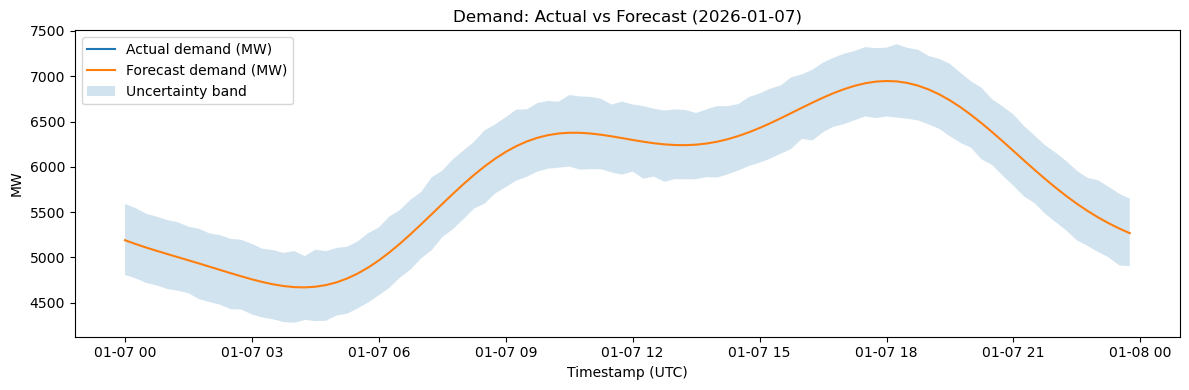

[metrics] No actuals available for this day (likely a future day).


In [5]:
# --- Visual: pick a forecast_date and plot actual vs forecast ---
import matplotlib.pyplot as plt
import numpy as np

# Pick a day to inspect (latest by default)
selected_date = sorted(df_dash["forecast_date"].unique())[-1]
print("[plot] selected forecast_date:", selected_date)

# Filter to that day; if you have multiple models, pick prophet_v1 if present
df_day = df_dash[df_dash["forecast_date"] == selected_date].copy()

if "prophet_v1" in df_day["model_name"].astype(str).unique():
    df_day = df_day[df_day["model_name"] == "prophet_v1"].copy()
    print("[plot] filtering to model_name='prophet_v1'")
else:
    # otherwise use the first model_name
    first_model = sorted(df_day["model_name"].astype(str).unique())[0]
    df_day = df_day[df_day["model_name"] == first_model].copy()
    print(f"[plot] filtering to model_name='{first_model}'")

# Convert ts_utc back to datetime for plotting
df_day["ts_utc_dt"] = pd.to_datetime(df_day["ts_utc"], utc=True, errors="coerce")
df_day = df_day.dropna(subset=["ts_utc_dt"]).sort_values("ts_utc_dt")

print("[plot] rows for selected date:", len(df_day))
display(df_day[["forecast_date","ts_utc","actual_demand_mw","forecast_demand_mw","yhat_lower","yhat_upper","model_name","train_days"]].head(5))

plt.figure(figsize=(12, 4))
plt.plot(df_day["ts_utc_dt"], df_day["actual_demand_mw"], label="Actual demand (MW)")
plt.plot(df_day["ts_utc_dt"], df_day["forecast_demand_mw"], label="Forecast demand (MW)")
plt.fill_between(df_day["ts_utc_dt"], df_day["yhat_lower"], df_day["yhat_upper"], alpha=0.2, label="Uncertainty band")
plt.title(f"Demand: Actual vs Forecast ({selected_date})")
plt.xlabel("Timestamp (UTC)")
plt.ylabel("MW")
plt.legend()
plt.tight_layout()
plt.show()

# Quick metrics (ignoring missing actuals)
eval_df = df_day.dropna(subset=["actual_demand_mw"]).copy()
if eval_df.empty:
    print("[metrics] No actuals available for this day (likely a future day).")
else:
    err = eval_df["actual_demand_mw"] - eval_df["forecast_demand_mw"]
    mae = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    mape = float(np.mean(np.abs(err) / eval_df["actual_demand_mw"])) * 100.0

    print("\n[metrics] (computed in Python)")
    print("  MAE (MW): ", round(mae, 2))
    print("  RMSE (MW):", round(rmse, 2))
    print("  MAPE (%): ", round(mape, 2))


### Error Metrics

To quantify forecast accuracy, the dashboard includes standard error measures:

- Absolute Error (MW): The raw difference between actual and forecast demand

- Mean Absolute Error (MAE): Average magnitude of forecast error, expressed in MW

- Root Mean Squared Error (RMSE): Penalizes larger errors more heavily than MAE

- Mean Absolute Percentage Error (MAPE): Error expressed as a percentage of actual demand

These metrics are calculated directly in Power BI using DAX, allowing them to respond dynamically to filters such as date range or model selection.

### Interpretation

Together, the chart and metrics allow you to:

- Visually inspect how closely forecasts track real demand

- Identify periods of over- or under-prediction

- Compare forecast performance across different days or models

- Assess whether forecast accuracy is improving or degrading over time

The dashboard is intentionally kept simple and explanatory, prioritizing clarity over complexity.

Its role is not to train models, but to evaluate outcomes produced by the automated pipeline.

### Dashboard Preview (Power BI)

The embedded PDF below shows a snapshot of the Power BI dashboard built on top of this pipeline.

Purpose of the dashboard:

- Visualise actual system demand vs next-day forecast demand at 15-minute resolution

- Quantify forecast accuracy using standard error metrics (MAE, RMSE, MAPE)

- Provide an analyst-friendly view of model performance over time

Data sourcing and refresh model:

- Forecasts and actuals are exported from SQLite into Parquet files

- Power BI reads these Parquet files directly

- This design avoids SQLite driver limitations in Power BI and keeps the pipeline decoupled from the reporting layer

- Dashboard refreshes are user-initiated, while the data pipeline remains fully automated

Interpretation notes:

- Each forecast curve represents a next-day prediction generated using only historical data available prior to the forecast date

- Overlapping forecast curves are expected when viewing multiple forecast dates together

- Forecast values are clipped at zero to respect physical constraints of electricity demand

This dashboard is intended as a validation and communication layer, not a control surface for the pipeline itself.

In [6]:
from IPython.display import IFrame, display

display(
    IFrame(
        src="eirgrid-pipeline_dashboard.pdf",
        width=900,
        height=600
    )
)


# 7. Summary
This project demonstrates a complete, end-to-end data engineering and forecasting workflow built with production principles in mind.

From raw API ingestion to analytics-ready outputs, the system shows how time-series energy data can be reliably collected, validated, transformed, forecasted, and evaluated.

Key competencies illustrated include:

- Designing a robust ingestion pipeline with retry logic, validation, and defensive parsing

- Handling time-zones and daylight-saving transitions correctly for operational data

- Implementing staging and canonical layers to ensure data quality and idempotency

- Building a repeatable daily workflow suitable for scheduling and automation

- Training rolling, non-leaky forecasts that reflect real operational constraints

- Persisting forecasts in a form suitable for downstream analytics and BI tools

- Evaluating model performance using standard forecasting error metrics

The architecture deliberately separates concerns:

- Python handles ingestion, transformation, forecasting, and export

- SQLite provides a lightweight, inspectable warehouse for development

- Parquet acts as a stable interchange format for analytics tools

- Power BI focuses solely on visualization and interpretation

This separation keeps the system modular, debuggable, and easy to extend. While the current implementation uses Prophet and SQLite, the same design patterns apply directly to larger-scale systems using PostgreSQL, cloud object storage, or orchestration frameworks such as Airflow or Prefect.

Overall, the project is intended to reflect how real-world data pipelines are built, tested, and evaluated — not just how models are trained, but how they are operationalized and assessed over time.